In [20]:
# import tensorflow as tf

# print(tf.__version__)

In [21]:
# import os
# os.environ.get("tf_upgrade_v2")

In [22]:
# !tf_upgrade_v2 \
#   --infile /home/hcxia/TradeMaster_dev/TradeMaster/data_synthesis/TimeGAN/timegan.py \
#   --outfile /home/hcxia/TradeMaster_dev/TradeMaster/data_synthesis/TimeGAN/timegan_v2_new.py \
#   --reportfile report.txt

In [23]:
# import tensorflow as tf

# print(tf.__version__)

In [24]:
# import os
# os.environ.get("tf_upgrade_v2")

# TimeGAN Tutorial

## Time-series Generative Adversarial Networks

- Paper: Jinsung Yoon, Daniel Jarrett, Mihaela van der Schaar, "Time-series Generative Adversarial Networks," Neural Information Processing Systems (NeurIPS), 2019.

- Paper link: https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks

- Last updated Date: April 24th 2020

- Code author: Jinsung Yoon (jsyoon0823@gmail.com)

This notebook describes the user-guide of a time-series synthetic data generation application using timeGAN framework. We use Stock, Energy, and Sine dataset as examples.

### Prerequisite
Clone https://github.com/jsyoon0823/timeGAN.git to the current directory.

## Necessary packages and functions call

- timegan: Synthetic time-series data generation module
- data_loading: 2 real datasets and 1 synthetic datasets loading and preprocessing
- metrics: 
    - discriminative_metrics: classify real data from synthetic data
    - predictive_metrics: train on synthetic, test on real
    - visualization: PCA and tSNE analyses

In [16]:
## Necessary packages
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import warnings
warnings.filterwarnings("ignore")

# 1. TimeGAN model
from style_timegan_rnn import styletimegan
# 2. Data loading
from data_loading import real_data_loading, sine_data_generation
# 3. Metrics
from metrics.discriminative_metrics import discriminative_score_metrics
from metrics.predictive_metrics import predictive_score_metrics
from metrics.visualization_metrics import visualization
import pandas as pd
from tqdm import tqdm
import pickle
import os

In [17]:
def get_intervals(data):
    index=data['index']
    last_value=index[0]-1
    last_index=0
    intervals=[]
    for i in range(data.shape[0]):
        if last_value!=index[i]-1:
            intervals.append([last_index,i])
            last_value=index[i]
            last_index=i
        last_value=index[i]
    intervals.append([last_index, i])
    return intervals

In [18]:
def interpolation(data):
    max_len=24
    l=len(data)
    to_fill=max_len-l
    if to_fill!=0:
        interval=max_len//to_fill
        for j in range(to_fill):
            idx=(interval+1)*j+interval
            data.insert(min(idx,len(data)-1),float('nan'))
    data=pd.Series(data).interpolate(method='polynomial', order=2)
    return data

In [19]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    norm_data = numerator / (denominator + 1e-7)
    return np.min(data, 0),np.max(data, 0),norm_data

In [20]:
def minmax_normlization(data):
    normalized_data=(data-data.min())/(data.max()-data.min())
    return normalized_data

In [21]:
def get_data_of_same_length(data,seq_len):
    data_processed=[]
    intervals=get_intervals(data)
    temp_data=[]
    data.drop(columns=['index'])
    for interval in intervals:
#         print(interval)
        data_seg=data.iloc[interval[0]:interval[1],:]
        for i in range(0, len(data_seg) - seq_len):
            _x = data_seg.iloc[i:i + seq_len,:]
            temp_data.append(_x)
    return temp_data

# Run through

In [22]:
def dataset_prepareation(path):
    data=pd.read_csv(path).reset_index()
    tics=data['tic'].unique()
    # features=[ 'open', 'high', 'low', 'close', 'adjcp','zopen', 'zhigh', 'zlow', 'zadjcp', 'zclose', 'zd_5', 'zd_10',
    #    'zd_15', 'zd_20', 'zd_25', 'zd_30', 'pct_return', 'adjcp_filtered',
    #    'pct_return_filtered','volume']
    features=['open','high','low','close','adjcp','volume']
    ret=[]
    for col in data.columns:
        if col in features:
            ret.append(col)
    features=ret
    min_sclar_by_tic={}
    max_sclar_by_tic={}
    for tic in tics:
        data_by_tic=data.loc[data['tic']==tic,features].astype(float)
        min_scalr,max_sclar,norm_data_by_tic=MinMaxScaler(data_by_tic)
        # print(min_scalr.shape)
        data.loc[data['tic']==tic,features]=norm_data_by_tic
        min_sclar_by_tic[tic]=min_scalr
        max_sclar_by_tic[tic]=max_sclar
    stock_group_num=len(data['stock_type'].unique())
    regime_num=len(data['label'].unique())
    for tic in tics:
        if not os.path.exists('./data/scalr/'):
            os.makedirs('./data/scalr/')
        with open('./data/scalr/'+str(tic)+'_minsclar'+'.pickle', 'wb') as handle:
            pickle.dump(min_sclar_by_tic[tic], handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open('./data/scalr/'+str(tic)+'_maxsclar'+'.pickle', 'wb') as handle:
            pickle.dump(max_sclar_by_tic[tic], handle, protocol=pickle.HIGHEST_PROTOCOL)
        for j in range(regime_num):
            data_seg=data.loc[(data['tic']==tic) & (data['label']==j),['index','open','high','low','close','adjcp','volume']]
    #         data_dict[(i,j)]=data_seg
            data_seg.to_csv('./data/data_seg_'+tic+'_'+str(j)+'.csv')
        

## Data Loading

Load original dataset and preprocess the loaded data.

- data_name: stock, energy, or sine
- seq_len: sequence length of the time-series data

In [32]:
# data=pd.read_csv('/home/hcxia/TradeMaster_dev/TradeMaster/data_synthesis/TimeGAN/GOOG_labeled_3_24.csv').reset_index()

In [33]:
# data=pd.read_csv("./DJI_all_labeled_3_24.csv").reset_index()

In [23]:
dataset_prepareation("../../data/data/other/DJI_all_labeled_3_24.csv")

In [24]:
dataset_prepareation('../../data/data/other/GOOG_labeled_3_24.csv')

# preprocess data by stock group and regime

Normalize features with in own tic

# Make data dict

In [25]:
def prepare_data_for_trainning(path,label,label_number=3):
    data=pd.read_csv(path).drop('index', axis=1)
    data=data.reset_index().rename(columns={data.index.name:'index'})
#     plt.plot(data['adjcp'])
#     plt.show()
#     display(data.head())
    data.to_csv('temp_data.csv')
    data=get_data_of_same_length(data,24)
#     for i in range(20):
#         plt.plot(data[i]['adjcp'])
#         plt.show()
#         print(i)
#         display(data[i])
#     display(len(data))
    data_res=[]
    label_res=[]
    for d in data:
        data_res.append(d.loc[:,['open','high','low','close','adjcp','volume']].to_numpy())
        label_temp=np.zeros(label_number)
        label_temp[label]=1
        label_res.append(label_temp)
    return data_res,label_res

### GOOG data

In [26]:
GOOG_data={}
GOOG_data_label={}
for i in range(3):
    GOOG_data['data_seg_GOOG_'+str(i)],GOOG_data_label['data_seg_GOOG_'+str(i)]=prepare_data_for_trainning('./data/data_seg_GOOG_'+str(i)+'.csv',i)
    print(i,len(GOOG_data['data_seg_GOOG_'+str(i)]))

0 673
1 1591
2 1529


### Single stock data

In [29]:
data=pd.read_csv("../../data/data/other/DJI_all_labeled_3_24.csv").reset_index()
tics=data['tic'].unique()
data_dict_tic={}
data_dict_tic_label={}
for tic in tics:
    data_dict_tic[tic]={}
    data_dict_tic_label[tic]={}
    for i in range(3):
        data_dict_tic[tic]['data_seg_'+str(tic)+'_'+str(i)],data_dict_tic_label[tic]['data_seg_'+str(tic)+'_'+str(i)]=prepare_data_for_trainning('./data/data_seg_'+str(tic)+'_'+str(i)+'.csv',i)
        print(tic,i,len(data_dict_tic[tic]['data_seg_'+str(tic)+'_'+str(i)]))

AAPL 0 1147
AAPL 1 1982
AAPL 2 2583
CSCO 0 1208
CSCO 1 2707
CSCO 2 1797
TRV 0 867
TRV 1 3239
TRV 2 1606
CAT 0 1319
CAT 1 2117
CAT 2 2276
UNH 0 647
UNH 1 2939
UNH 2 2126
BA 0 1332
BA 1 2362
BA 2 2018
VZ 0 886
VZ 1 3713
VZ 2 1113
CVX 0 840
CVX 1 3201
CVX 2 1671
PG 0 460
PG 1 4131
PG 2 1121
HD 0 1094
HD 1 2645
HD 2 1973
GS 0 1140
GS 1 2737
GS 2 1835
MSFT 0 956
MSFT 1 3130
MSFT 2 1626
DIS 0 954
DIS 1 3054
DIS 2 1704
NKE 0 967
NKE 1 2592
NKE 2 2153
HON 0 904
HON 1 3137
HON 2 1671
MMM 0 813
MMM 1 3439
MMM 2 1460
INTC 0 1363
INTC 1 2440
INTC 2 1909
KO 0 394
KO 1 4438
KO 2 880
JNJ 0 290
JNJ 1 4546
JNJ 2 876
JPM 0 1099
JPM 1 2731
JPM 2 1882
IBM 0 940
IBM 1 3272
IBM 2 1500
MCD 0 714
MCD 1 3668
MCD 2 1330
WBA 0 948
WBA 1 3243
WBA 2 1521
AXP 0 1003
AXP 1 3140
AXP 2 1569
MRK 0 1015
MRK 1 3193
MRK 2 1504
WMT 0 695
WMT 1 3919
WMT 2 1098
AMGN 0 1051
AMGN 1 3073
AMGN 2 1588


### Stock group data

In [30]:
data=pd.read_csv("../../data/data/other/DJI_all_labeled_3_24.csv").reset_index()
# display(data.columns)
tic_group_pair=data.loc[:,['tic','stock_type']]
tic_group_pair=tic_group_pair.groupby(['tic','stock_type']).size().reset_index(name='Freq')
stock_group_num=len(data['stock_type'].unique())
tic_in_group={}
for group in range(stock_group_num):
#     if group not in tic_in_group：
#         tic_in_group[group]=[]
    tic_in_group[group]=list(tic_group_pair.loc[tic_group_pair['stock_type']==group,:]['tic'].unique())

In [32]:
print(tic_in_group)

{0: ['BA', 'HD', 'MSFT', 'UNH'], 1: ['AXP', 'DIS', 'JPM', 'PG', 'WMT'], 2: ['AAPL', 'NKE'], 3: ['AMGN', 'CAT', 'CVX', 'HON', 'IBM', 'JNJ', 'MCD', 'MMM', 'TRV'], 4: ['CSCO', 'INTC', 'KO', 'MRK', 'VZ', 'WBA'], 5: ['GS']}


In [31]:
data=pd.read_csv("../../data/data/other/DJI_all_labeled_3_24.csv").reset_index()
stock_group_num=len(data['stock_type'].unique())
data_dict_group={}
data_dict_group_label={}
for group in range(stock_group_num):
    data_dict_group[group]={}
    data_dict_group_label[group]={}
    for i in range(3):
        if 'data_seg_'+str(group)+'_'+str(i) not in data_dict_group[group]:
            data_dict_group[group]['data_seg_'+str(group)+'_'+str(i)]=[]
            data_dict_group_label[group]['data_seg_'+str(group)+'_'+str(i)]=[]
        for tic in tic_in_group[group]:
            data_dict_group[group]['data_seg_'+str(group)+'_'+str(i)].extend(data_dict_tic[tic]['data_seg_'+str(tic)+'_'+str(i)])
            data_dict_group_label[group]['data_seg_'+str(group)+'_'+str(i)].extend(data_dict_tic_label[tic]['data_seg_'+str(tic)+'_'+str(i)])
        print(group,i,len(data_dict_group[group]['data_seg_'+str(group)+'_'+str(i)]))

0 0 4029
0 1 11076
0 2 7743
1 0 4211
1 1 16975
1 2 7374
2 0 2114
2 1 4574
2 2 4736
3 0 7738
3 1 29692
3 2 13978
4 0 5814
4 1 19734
4 2 8724
5 0 1140
5 1 2737
5 2 1835


### All dji stock data

In [33]:
data_all={}
data_all_label={}
for i in range(3):
    if 'data_seg_'+'all'+'_'+str(i) not in data_all:
        data_all['data_seg_'+'all'+'_'+str(i)]=[]
        data_all_label['data_seg_'+'all'+'_'+str(i)]=[]
    for tic in tics:
        data_all['data_seg_'+'all'+'_'+str(i)].extend(data_dict_tic[tic]['data_seg_'+str(tic)+'_'+str(i)])
        data_all_label['data_seg_'+'all'+'_'+str(i)].extend(data_dict_tic_label[tic]['data_seg_'+str(tic)+'_'+str(i)])
    print(i,len(data_all['data_seg_'+'all'+'_'+str(i)]))

0 25046
1 84788
2 44390


# Style Training dataset

In [34]:
style_training_data=[]
style_training_label=[]
for i in range(3):
    style_training_data.extend(data_all['data_seg_'+'all'+'_'+str(i)])
    style_training_label.extend(data_all_label['data_seg_'+'all'+'_'+str(i)])

## Training helper

# data set:

- GOOG_data
- data_dict_tic (dict of dict by tic)
- data_dict_group (dict of dict by group num)
- data_all

## Set network parameters

TimeGAN network parameters should be optimized for different datasets.

- module: gru, lstm, or lstmLN
- hidden_dim: hidden dimensions
- num_layer: number of layers
- iteration: number of training iterations
- batch_size: the number of samples in each batch

In [44]:
print(GOOG_data.keys())
print(data_dict_tic.keys())
print(data_dict_group.keys())
print(data_all.keys())

dict_keys(['data_seg_GOOG_0', 'data_seg_GOOG_1', 'data_seg_GOOG_2'])
dict_keys(['AAPL', 'CSCO', 'TRV', 'CAT', 'UNH', 'BA', 'VZ', 'CVX', 'PG', 'HD', 'GS', 'MSFT', 'DIS', 'NKE', 'HON', 'MMM', 'INTC', 'KO', 'JNJ', 'JPM', 'IBM', 'MCD', 'WBA', 'AXP', 'MRK', 'WMT', 'AMGN'])
dict_keys([0, 1, 2, 3, 4, 5])
dict_keys(['data_seg_all_0', 'data_seg_all_1', 'data_seg_all_2'])


In [35]:
def training(data_set_dict,label_set_dict,style_training_data,style_training_label,style_training=True,only_style_training=False,from_join_training=False):
    parameters = dict()
    parameters['module'] = 'gru' 
    parameters['hidden_dim'] = 24
    parameters['num_layer'] = 3
    parameters['iterations'] = 50000
    parameters['batch_size'] = 128
    gnerated_dataset_dict={}
    for dataset_name, data_set in data_set_dict.items():
        print(str(dataset_name))
        label=int(dataset_name[-1])
        print(label)
        # styletimegan(ori_data, parameters,training_label,nb_classes,label,style_training_data,style_training=True,only_style_training=False,save_name=None,from_join_training=False):
        try:
            print('training setting is: ','only_style_training: ',only_style_training,'\n','style_training: ',style_training,"\n","from_join_training: ",from_join_training,'\n')
            gnerated_dataset_dict[dataset_name] = styletimegan(ori_data=data_set,
                                                               parameters=parameters,
                                                               style_training_label=style_training_label,
                                                               save_name=str(dataset_name),
                                                               label=label_set_dict[dataset_name],
                                                              nb_classes=3,
                                                              style_training_data=style_training_data,
                                                               style_training=style_training,
                                                              only_style_training=only_style_training,
                                                               from_join_training=from_join_training
                                                              )
        except:
            print('run setting fails, run the full course')
            gnerated_dataset_dict[dataset_name] = styletimegan(ori_data=data_set,
                                                               parameters=parameters,
                                                               style_training_label=style_training_label,
                                                               save_name=str(dataset_name),
                                                               label=label_set_dict[dataset_name],
                                                              nb_classes=3,
                                                              style_training_data=style_training_data,
                                                               style_training=style_training,
                                                              only_style_training=False,
                                                               from_join_training=False
                                                              )
        if only_style_training:
            break
    return gnerated_dataset_dict

In [36]:
import importlib
# importlib.reload(styletimegan)
%load_ext autoreload
%autoreload 2

In [37]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0,1,2,3

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0,1,2,3


In [38]:
import torch
torch.cuda.device_count()

4

## Style discriminator pretrain

In [ ]:
GOOG_data_generated=training(data_set_dict=GOOG_data,
                             label_set_dict=GOOG_data_label,
                             style_training_data=style_training_data,
                             style_training_label=style_training_label,
                             style_training=True,
                             only_style_training=True,
                             from_join_training=False
                            )

data_seg_GOOG_0
0
training setting is:  only_style_training:  True 
 style_training:  True 
 from_join_training:  False 





Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * htt

2023-01-25 14:19:24.160746: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-01-25 14:19:24.219514: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce RTX 3090 major: 8 minor: 6 memoryClockRate(GHz): 1.695
pciBusID: 0000:18:00.0
2023-01-25 14:19:24.220560: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 1 with properties: 
name: GeForce RTX 3090 major: 8 minor: 6 memoryClockRate(GHz): 1.695
pciBusID: 0000:3b:00.0
2023-01-25 14:19:24.221484: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 2 with properties: 
name: GeForce RTX 3090 major: 8 minor: 6 memoryClockRate(GHz): 1.695
pciBusID: 0000:86:00.0
2023-01-25 14:19:24.222469: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 3 with properties: 
name: GeForce RTX 3090 major: 8 minor: 6 memoryClockRate(GHz): 1.695
pciBusID: 0000:af:00.0
2023-01-25 14:19:24

2023-01-25 14:19:24.829706: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x22eb3520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-25 14:19:24.829755: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): GeForce RTX 3090, Compute Capability 8.6
2023-01-25 14:19:24.829768: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): GeForce RTX 3090, Compute Capability 8.6
2023-01-25 14:19:24.829779: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): GeForce RTX 3090, Compute Capability 8.6
2023-01-25 14:19:24.829789: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (3): GeForce RTX 3090, Compute Capability 8.6
2023-01-25 14:19:24.830328: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-25 14:19:24.830356: I tensorflow/core/common_runtime/gpu/gpu_d

# Training 

In [ ]:
GOOG_data_generated=training(data_set_dict=GOOG_data,
                             label_set_dict=GOOG_data_label,
                             style_training_data=style_training_data,
                             style_training_label=style_training_label,
                             style_training=False,
                             only_style_training=False,
                             from_join_training=False
                            )

In [ ]:
data_dict_group_3_generated=training(data_set_dict=data_dict_group[3],
                             label_set_dict=data_dict_group_label[3],
                             style_training_data=style_training_data,
                             style_training_label=style_training_label,
                             style_training=False,
                             only_style_training=False,
                             from_join_training=False
                            )

In [ ]:
data_all_generated=training(data_set_dict=data_all,
                             label_set_dict=data_all_label,
                             style_training_data=style_training_data,
                             style_training_label=style_training_label,
                             style_training=False,
                             only_style_training=False,
                             from_join_training=False
                            )

In [ ]:
data_dict_tic_generated={}
for tic in data_dict_tic.keys():
    if tic not in data_dict_tic_generated:
        data_dict_tic_generated[tic]=training(data_dict_tic[tic])

In [ ]:
data_dict_tic_APPL_generated=training(data_dict_tic['AAPL'])
data_dict_group_3_generated=training(data_dict_group[3])
GOOG_data_generated=training(GOOG_data)
data_all_generated=training(data_all)

In [ ]:
data_dict_group_4_generated=training(data_dict_group[4])

# Load Generated Data

In [14]:
import pickle

data_to_load=['GOOG_data_generated',
'data_dict_group_3_generated',
'data_all_generated']
load_data_dict={}
for data in data_to_load:
    with open( './generated_data/style/'+data+'_style.pickle', 'rb') as handle:
        load_data_dict[data] = pickle.load(handle)

## Save generated data

In [41]:
data_to_save=[
data_dict_tic_APPL_generated,
data_dict_group_3_generated,
GOOG_data_generated,
data_all_generated,
data_dict_group_4_generated
]
for tic in data_dict_tic_generated.keys():
    locals()['data_dict_tic_'+tic+'_generated']=data_dict_tic_generated[tic]
    data_to_save.append(locals()['data_dict_tic_'+tic+'_generated'])

NameError: name 'data_dict_tic_APPL_generated' is not defined

In [ ]:
data_to_save=[
GOOG_data_generated,
data_dict_group_3_generated,
data_all_generated
]

In [ ]:
import pickle
import inspect


def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]
for i in range(len(data_to_save)):
    try:
        with open('./generated_data/style/'+retrieve_name(data_to_save[i])[-1]+'_style.pickle', 'wb') as handle:
            pickle.dump(data_to_save[i], handle, protocol=pickle.HIGHEST_PROTOCOL)
        print('writen to '+retrieve_name(data_to_save[i])[-1]+'.pickle')
    except:
        print('skip this')

## Evaluate the generated data



In [49]:
def dis_score(ori_data, generated_data):
    metric_iteration = 5
    discriminative_score = list()
    for _ in range(metric_iteration):
        temp_disc = discriminative_score_metrics(ori_data, generated_data)
        discriminative_score.append(temp_disc)
    print('Discriminative score: ' + str(np.round(np.mean(discriminative_score), 4)))
    return np.round(np.mean(discriminative_score), 4)

def pred_score(ori_data, generated_data):
    predictive_score = list()
    metric_iteration = 5
    for tt in range(metric_iteration):
        temp_pred = predictive_score_metrics(ori_data, generated_data)
        predictive_score.append(temp_pred)   
    print('Predictive score: ' + str(np.round(np.mean(predictive_score), 4)))
    return np.round(np.mean(predictive_score), 4)
    
def evaluation(data_set_dict,genrated_data_set_dict):
    length_dict={}
    discriminative_score_dict={}
    predictive_score_dict={}
    for dataset_name, data_set in data_set_dict.items():
        length_dict[dataset_name]=len(data_set_dict[dataset_name])
        discriminative_score_dict[dataset_name] = dis_score(data_set_dict[dataset_name],genrated_data_set_dict[dataset_name])
        predictive_score_dict[dataset_name] = pred_score(data_set_dict[dataset_name],genrated_data_set_dict[dataset_name])
        visualization(data_set_dict[dataset_name],genrated_data_set_dict[dataset_name], 'pca')
        visualization(data_set_dict[dataset_name],genrated_data_set_dict[dataset_name], 'tsne')
    return length_dict,discriminative_score_dict,predictive_score_dict

In [16]:
data_dict_tic_res={}
for tic in data_dict_tic.keys():
    if tic not in data_dict_tic_res:
        data_dict_tic_res[tic]=[evaluation(data_dict_tic[tic],data_dict_tic_generated[tic])]

NameError: name 'data_dict_tic' is not defined

In [ ]:
# data_dict_tic_APPL_generated=training(data_dict_tic['AAPL'])
# data_dict_group_3_generated=training(data_dict_group[3])
# GOOG_data_generated=training(GOOG_data)
# data_all_generated=training(data_all)

In [18]:
print(load_data_dict.keys())

dict_keys(['GOOG_data_generated', 'data_dict_group_3_generated', 'data_all_generated'])






Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instr

2023-01-23 15:10:16.717435: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-01-23 15:10:16.717583: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 15:10:16.717813: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: NVIDIA RTX A6000 major: 8 minor: 6 memoryClockRate(GHz): 1.8
pciBusID: 0000:21:00.0
2023-01-23 15:10:16.717868: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 15:10:16.718031: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 1 with properties: 
name: NVIDIA RTX A6000 major: 8 minor: 6 memoryClockRate(GHz): 1.8
pciBusID: 0000:22:00.0
202

2023-01-23 15:10:16.990567: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 15:10:16.993730: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 15:10:16.999552: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 15:10:17.003820: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 15:10:17.004176: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xd2a5260 initialized for plat

Discriminative score: 0.4244



2023-01-23 15:11:18.754156: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:11:18.754188: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:11:49.433034: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:11:49.433063: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:12:17.811060: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:12:17.811157: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:12:44.552764: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:12:44.552786: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:13:08.901515: I tensorflow

Predictive score: 0.0799


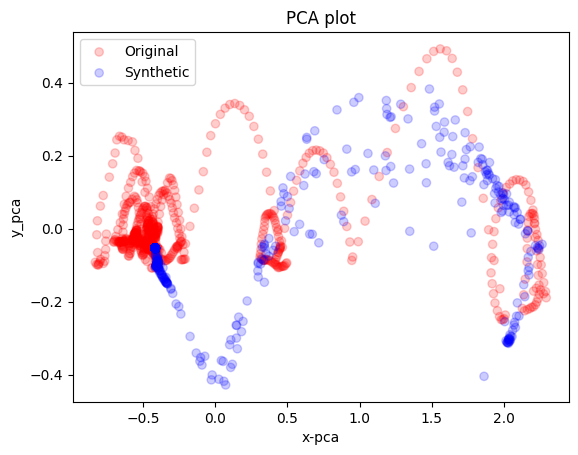

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1346 samples in 0.000s...
[t-SNE] Computed neighbors for 1346 samples in 0.045s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1346
[t-SNE] Computed conditional probabilities for sample 1346 / 1346
[t-SNE] Mean sigma: 0.000765
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.229820
[t-SNE] KL divergence after 300 iterations: 0.575793


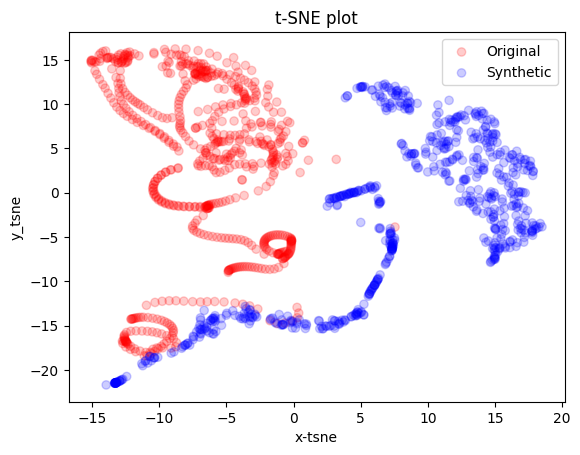

2023-01-23 15:13:36.172892: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:13:36.172922: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:13:46.583584: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:13:46.583617: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:13:57.332211: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:13:57.332232: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:14:08.085649: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:14:08.085673: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:14:18.773918: I tensorflow

Discriminative score: 0.3558


2023-01-23 15:14:29.054094: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:14:29.054120: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:14:53.703772: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:14:53.703795: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:15:20.135077: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:15:20.135104: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:15:46.022407: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:15:46.022434: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:16:10.939922: I tensorflow

Predictive score: 0.0227


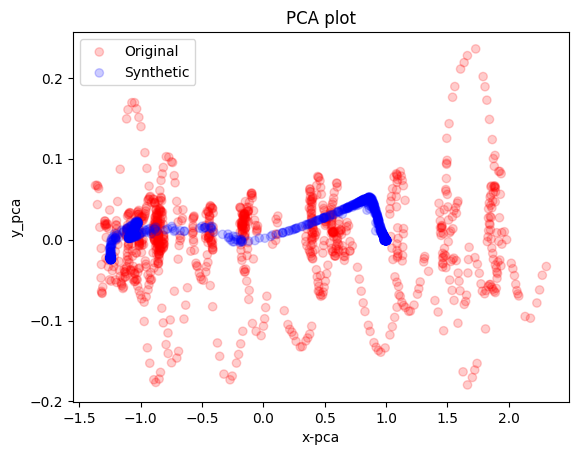

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.084s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.003876
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.994839
[t-SNE] KL divergence after 300 iterations: 0.618520


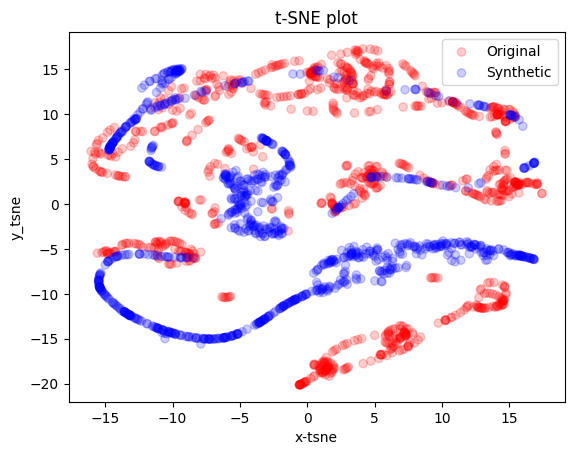

2023-01-23 15:16:40.250531: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:16:40.250558: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:16:50.834444: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:16:50.834474: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:17:01.962135: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:17:01.962164: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:17:13.230435: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:17:13.230460: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:17:24.199598: I tensorflow

Discriminative score: 0.4467


2023-01-23 15:17:34.766637: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:17:34.766656: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:18:03.896655: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:18:03.896677: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:18:28.632837: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:18:28.632861: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:18:55.477598: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:18:55.477626: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:19:22.593809: I tensorflow

Predictive score: 0.055


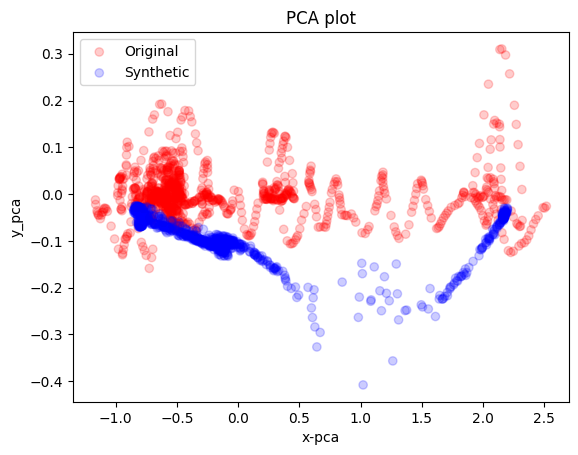

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.087s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.020198
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.239346
[t-SNE] KL divergence after 300 iterations: 0.645652


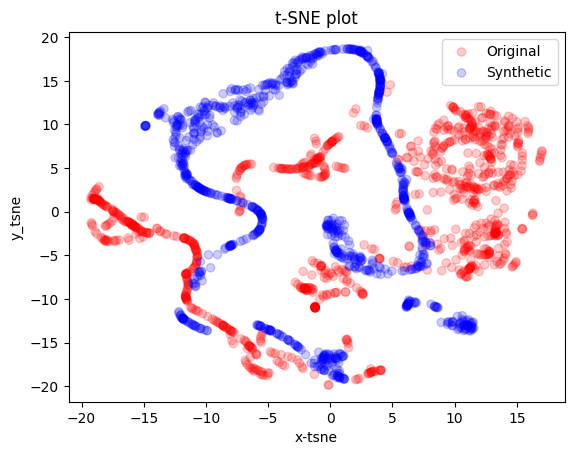

In [50]:
GOOG_data_res=[evaluation(GOOG_data,load_data_dict['GOOG_data_generated'])]

2023-01-23 15:19:53.260514: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:19:53.260536: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:20:04.514551: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:20:04.514574: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:20:15.834139: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:20:15.834249: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:20:27.084705: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:20:27.084728: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:20:38.287203: I tensorflow

Discriminative score: 0.3866


2023-01-23 15:20:48.816877: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:20:48.816910: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:21:16.450552: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:21:16.450576: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:21:44.230472: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:21:44.230501: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:22:11.523097: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:22:11.523120: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:22:39.878385: I tensorflow

Predictive score: 0.0579


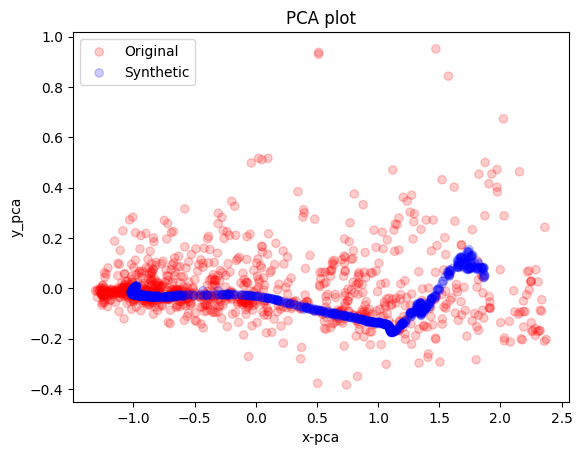

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.101s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.012660
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.879017
[t-SNE] KL divergence after 300 iterations: 0.648922


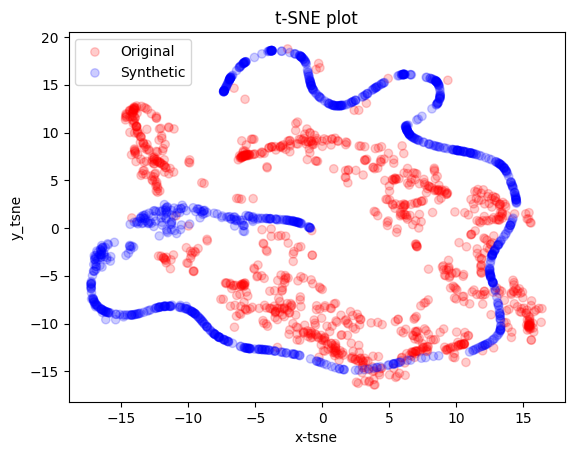

2023-01-23 15:23:10.962849: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:23:10.962878: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:23:23.147087: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:23:23.147115: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:23:36.026259: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:23:36.026294: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:23:48.394157: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:23:48.394186: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:24:00.682164: I tensorflow

Discriminative score: 0.3047


2023-01-23 15:24:12.891486: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:24:12.891515: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:24:45.102540: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:24:45.102566: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:25:16.305758: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:25:16.305779: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:25:48.290495: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:25:48.290517: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:26:20.154879: I tensorflow

Predictive score: 0.0378


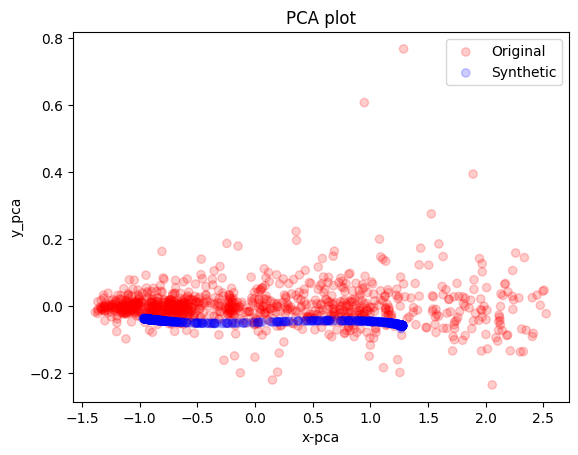

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.083s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.002944
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.547028
[t-SNE] KL divergence after 300 iterations: 0.536185


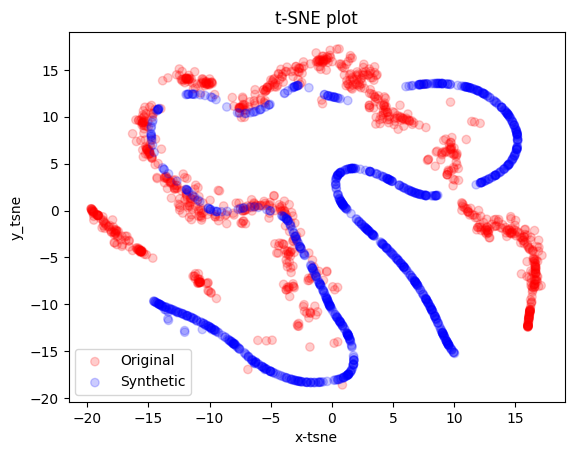

2023-01-23 15:26:55.309454: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:26:55.309478: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:27:06.807593: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:27:06.807713: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:27:18.275348: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:27:18.275376: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:27:29.662565: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:27:29.662594: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:27:41.019946: I tensorflow

Discriminative score: 0.4691


2023-01-23 15:27:52.714991: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:27:52.715019: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:28:22.782642: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:28:22.782674: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:28:52.473092: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:28:52.473124: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:29:21.471611: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:29:21.471634: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:29:51.684790: I tensorflow

Predictive score: 0.0749


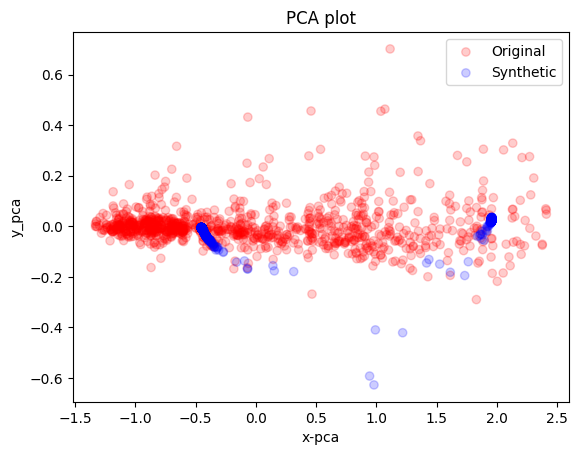

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.082s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.001821
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.803654
[t-SNE] KL divergence after 300 iterations: 0.603935


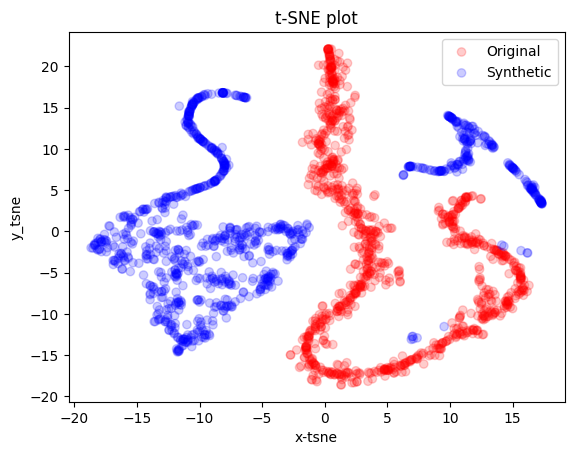

In [51]:
group_3_res=[evaluation(data_dict_group[3],load_data_dict['data_dict_group_3_generated'])]

2023-01-23 15:30:22.423073: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:30:22.423100: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:30:34.306352: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:30:34.306379: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:30:46.565202: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:30:46.565312: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:30:58.158637: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:30:58.158663: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:31:10.353614: I tensorflow

Discriminative score: 0.402


2023-01-23 15:31:22.048854: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:31:22.048880: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:31:53.240798: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:31:53.240818: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:32:23.343766: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:32:23.343795: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:32:54.837454: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:32:54.837483: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:33:25.494768: I tensorflow

Predictive score: 0.0595


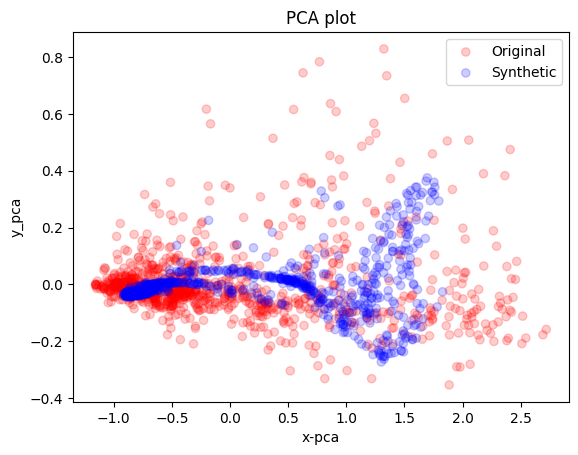

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.087s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.018825
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.104122
[t-SNE] KL divergence after 300 iterations: 0.675927


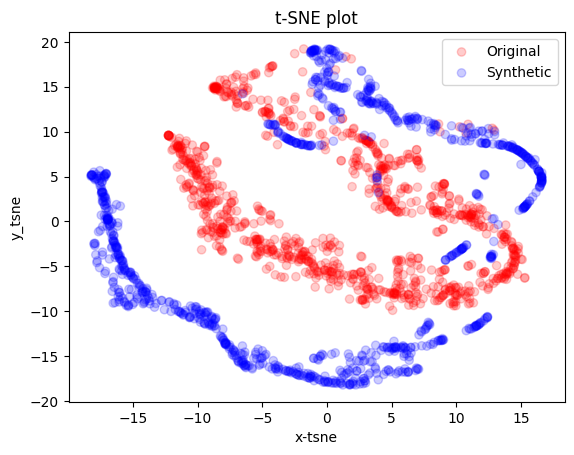

2023-01-23 15:33:59.821846: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:33:59.821870: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:34:14.656606: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:34:14.656635: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:34:29.450238: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:34:29.450263: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:34:44.790107: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:34:44.790131: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:34:59.923226: I tensorflow

Discriminative score: 0.2856


2023-01-23 15:35:13.922668: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:35:13.922693: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:35:55.430129: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:35:55.430153: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:36:36.396485: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:36:36.396603: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:37:18.416050: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:37:18.416079: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:37:59.529850: I tensorflow

Predictive score: 0.0411


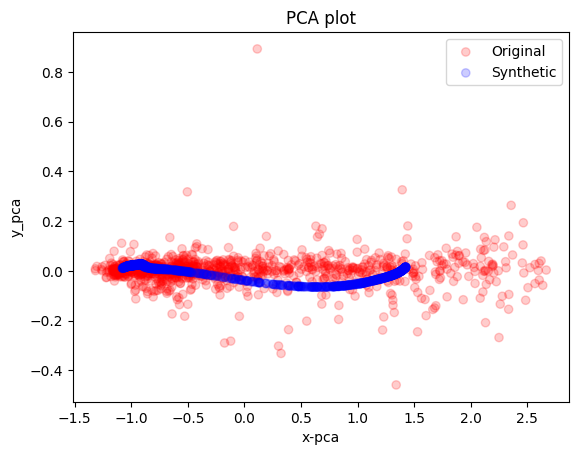

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.078s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.013789
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.308842
[t-SNE] KL divergence after 300 iterations: 0.559126


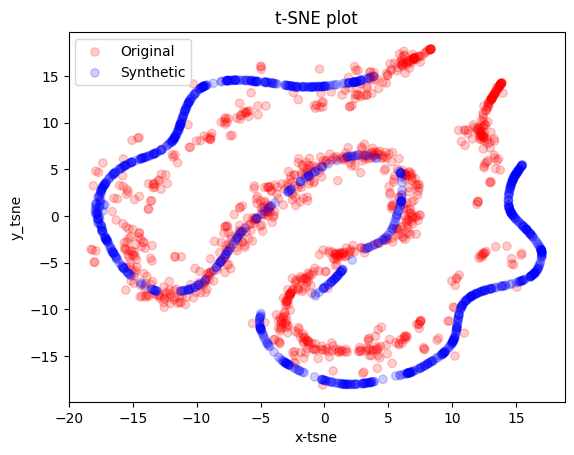

2023-01-23 15:38:43.337675: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:38:43.337701: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:38:56.705110: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:38:56.705137: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:39:09.700513: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:39:09.700537: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:39:22.704296: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:39:22.704323: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:39:36.113447: I tensorflow

Discriminative score: 0.3731


2023-01-23 15:39:48.975589: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:39:48.975624: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:40:23.590979: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:40:23.591008: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:40:58.570730: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:40:58.570861: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:41:33.144568: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1159] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-01-23 15:41:33.144601: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1165]      
2023-01-23 15:42:07.602544: I tensorflow

Predictive score: 0.0468


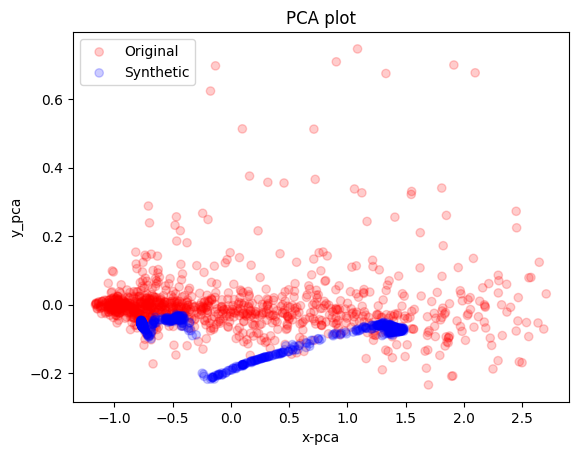

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.087s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.004322
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.946468
[t-SNE] KL divergence after 300 iterations: 0.641752


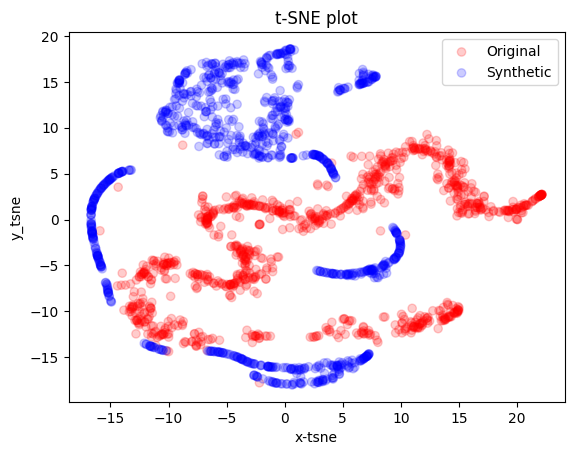

In [52]:
all_data_res=[evaluation(data_all,load_data_dict['data_all_generated'])]

In [ ]:
AAPL_res=[evaluation(data_dict_tic['AAPL'],data_dict_tic_APPL_generated)]
group_3_res=[evaluation(data_dict_group[3],data_dict_group_3_generated)]

In [47]:
print(GOOG_data_res)

[({'data_seg_GOOG_0': 673, 'data_seg_GOOG_1': 1591, 'data_seg_GOOG_2': 1529}, {'data_seg_GOOG_0': 0.4778, 'data_seg_GOOG_1': 0.4806, 'data_seg_GOOG_2': 0.3585}, {'data_seg_GOOG_0': 0.0693, 'data_seg_GOOG_1': 0.0289, 'data_seg_GOOG_2': 0.0697})]


In [ ]:
all_data_res=[evaluation(data_all,data_all_generated)]

In [ ]:
group_4_res=[evaluation(data_dict_group[4],data_dict_group_4_generated)]

## result analysis

In [ ]:
display(GOOG_data_res)

In [ ]:
display(AAPL_res)

In [ ]:
display(group_3_res)

In [ ]:
display(all_data_res)

In [ ]:
display(group_4_res)

In [ ]:
data_dict_tic_res={}
for tic in data_dict_tic_res.keys():
    display(data_dict_tic_res[tic])

In [ ]:
visualization(GOOG_processed_data,GOOG_genrated_data, 'pca')
visualization(GOOG_processed_data,GOOG_genrated_data, 'tsne')

In [ ]:
for k in data_dict.keys():
    print('vis of '+k)
    visualization(data_dict[k], generated_data_dict[k], 'pca')
    visualization(data_dict[k], generated_data_dict[k], 'tsne')

# Leverage Effect

In [ ]:
def get_std_list(data):
    intervals=get_intervals(data)
    std_list=[]
    data.drop(columns=['index'])
    for interval in intervals:
        data_seg=data.iloc[interval[0]:interval[1],:].pct_return.to_numpy()
        std=data_seg.std()
        std_list.append(std)
    return std_list

single stock

In [ ]:
for tic in tics:
    for j in range(regime_num):
        data=pd.read_csv('data_seg_'+tic+'_'+str(j)+'.csv')
        print('stock',tic,'regime',j)
        std_list=get_std_list(data)
        display(pd.DataFrame(std_list).describe()) 

by stock group

In [ ]:
for i in range(stock_group_num):
    for j in range(regime_num):
        data=pd.read_csv('data_seg_'+str(i)+'_'+str(j)+'.csv')
        print('stock',i,'regime',j)
        std_list=get_std_list(data)
        display(pd.DataFrame(std_list).describe()) 

In [ ]:
def get_std_list(data):
    intervals=get_intervals(data)
    std_list=[]
    data.drop(columns=['index'])
    for interval in intervals:
        data_seg=data.iloc[interval[0]:interval[1],:].to_numpy()
        std=data_seg.adj.std()
        std_list.append(std)
    return std_list

# key takeaway
1. regime 0 has high variance mean and high variance variance
2. regime 1 has low variance mean and low variance variance
3. regime 2 has low variance mean and low/high variance variance

# Pre-train Static learning classification discriminator

In [ ]:
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.datasets import load_arrow_head
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sktime.classification.kernel_based import RocketClassifier

In [ ]:
def get_data_of_same_length_df(data,seq_len):
    data_processed=[]
    intervals=get_intervals(data)
    temp_data=[]
    data.drop(columns=['index'])
    for interval in intervals:
        data_seg=data.iloc[interval[0]:interval[1],:]
        for i in range(0, len(data_seg) - seq_len):
            _x = data[i:i + seq_len]
            temp_data.append(_x)
    return temp_data

In [ ]:
data=pd.read_csv('data_seg_'+"0"+'_'+"0"+'.csv')
display(data.columns)

In [ ]:
for tic in tics:
    print(tic)
    X=[]
    y=np.empty(0)
    for j in range(regime_num):
        data=pd.read_csv('data_seg_'+tic+'_'+str(j)+'.csv').loc[:,['index', 'open', 'high', 'low', 'close', 'adjcp',
       'pct_return', 'adjcp_filtered', 'pct_return_filtered']]
        process_data=get_data_of_same_length_df(data,24)
        label=np.full(len(process_data), j)
        X.extend(process_data)
        y=np.concatenate((y, label), axis=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    classifier = RocketClassifier(num_kernels=2000,n_jobs=-1)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print(accuracy_score(y_test, y_pred))

ALL single stock classification have unbelieve 100% acc?

In [ ]:
for i in range(stock_group_num):
    print('stock_group',i)
    X=[]
    y=np.empty(0)
    for j in range(regime_num):
        data=pd.read_csv('data_seg_'+str(i)+'_'+str(j)+'.csv').loc[:,['index', 'open', 'high', 'low', 'close', 'adjcp',
       'pct_return', 'adjcp_filtered', 'pct_return_filtered']]
        process_data=get_data_of_same_length_df(data,24)
        label=np.full(len(process_data), j)
        X.extend(process_data)
        y=np.concatenate((y, label), axis=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    classifier = RocketClassifier(num_kernels=2000,n_jobs=-1,use_multivariate='yes')
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    print(accuracy_score(y_test, y_pred))

Still 1.0?

In [ ]:

# X_train, X_test, y_train, y_test = train_test_split(X, y)
# classifier = TimeSeriesForestClassifier()
# classifier.fit(X_train, y_train)
# y_pred = classifier.predict(X_test)
# accuracy_score(y_test, y_pred)

# Pre-train Deep learning classification discriminator

### training

In [ ]:
from tsai.all import *
my_setup()

In [ ]:
for i in range(stock_group_num):
    print('stock_group',i)
    X=[]
    y=np.empty(0)
    for j in range(regime_num):
        data=pd.read_csv('data_seg_'+str(i)+'_'+str(j)+'.csv').loc[:,['index', 'open', 'high', 'low', 'close', 'adjcp',
       'pct_return', 'adjcp_filtered', 'pct_return_filtered']]
        process_data=get_data_of_same_length(data,24)
        label=np.full(len(process_data), j)
        X.extend([p.transpose() for p in process_data])
        y=np.concatenate((y, label), axis=0)
    X=np.array(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])
    tfms  = [None, [Categorize()]]
    dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
    dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)
    model = InceptionTime(dls.vars, dls.c)
    learn = Learner(dls, model, metrics=accuracy)
    learn.fit_one_cycle(25, lr_max=1e-3)
    learn.plot_metrics()
    learn.save_all(path='export', dls_fname='dls_'+str(i)+'_'+str(j), model_fname='model_'+str(i)+'_'+str(j), learner_fname='learner_'+str(i)+'_'+str(j))
#     display(type(X_train),X_train.shape)

# Key takeaway

InceptionTime can do the job

In [ ]:
X, y, splits = get_classification_data('LSST', split_data=False)

In [ ]:
tfms  = [None, TSClassification()] # TSClassification == Categorize
batch_tfms = TSStandardize()
dls = get_ts_dls(X, new_y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=[64, 128])
dls.dataset

In [ ]:
def get_std_list(data):
    intervals=get_intervals(data)
    std_list=[]
    data.drop(columns=['index'])
    for interval in intervals:
        data_seg=data.iloc[interval[0]:interval[1],:].to_numpy()
        std=data_seg.adj.std()
        std_list.append(std)
    return std_list

In [ ]:
batch_tfms = TSStandardize(by_sample=True)
mv_clf = TSClassifier(X, y, splits=splits, path='models', arch=InceptionTimePlus, batch_tfms=batch_tfms, metrics=accuracy, cbs=ShowGraph())
mv_clf.fit_one_cycle(10, 1e-2)
mv_clf.export("mv_clf.pkl")

## inference

## inference